In [1]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

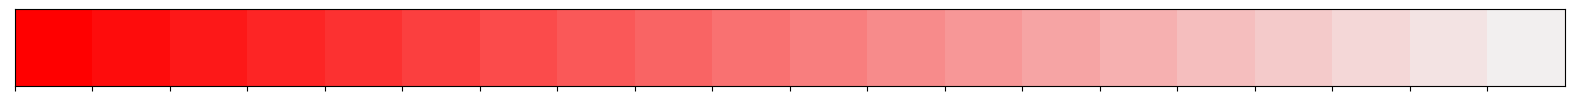

In [2]:
# задание палитры цветов
color_palette = sns.light_palette('red', n_colors=20, reverse=True)
sns.palplot(color_palette)
plt.show()

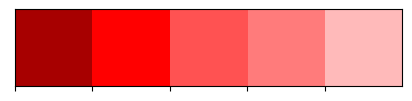

In [3]:
# задание палитры цветов
colors = ['#a70000', '#ff0000', '#ff5252', '#ff7b7b', '#ffbaba']
sns.palplot(sns.color_palette(colors))

In [4]:
import matplotlib.colors as mcolors


def make_colormap(seq):
    
    """ функция создания пользовательского
            масштабируемого цвета """
    
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

In [5]:
# задание палитры цветов красного
c = mcolors.ColorConverter().to_rgb
rvb = make_colormap([c('darkred'), c('brown'), 0.20, c('brown'), c('red'), 0.40, c('red'), \
                     c('indianred'), 0.60, c('indianred'), c('lightcoral'), 0.80, c('lightcoral')])

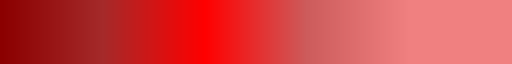

In [6]:
# вывод пользовательской палитры
rvb

In [7]:
# считывание данных с геоданными Московской агломерации
adm = pd.read_csv('data_clean/adm.csv')

In [8]:
# вывод данных
adm.head()

,geometry,cell_zid,adm_name,okrug_name,sub_ter,area,conts_zid
0,MULTIPOLYGON (((38.6495389842383 54.2597139180...,0,Серебряные пруды,Серебряные пруды,Московская область,0.25,1
1,MULTIPOLYGON (((38.6549362377517 54.2572466621...,1,Серебряные пруды,Серебряные пруды,Московская область,0.25,1
2,MULTIPOLYGON (((38.6625773861122 54.2560891872...,2,Серебряные пруды,Серебряные пруды,Московская область,0.25,1
3,MULTIPOLYGON (((38.670279125503 54.25708620909...,3,Серебряные пруды,Серебряные пруды,Московская область,0.25,1
4,MULTIPOLYGON (((38.6779821287111 54.2581143832...,4,Серебряные пруды,Серебряные пруды,Московская область,0.25,1


In [9]:
# импорт библиотеки для работы с географическими координатами
from shapely import wkt

In [10]:
# преобразование признака в географические координаты
adm['geometry'] = adm['geometry'].apply(wkt.loads)

In [11]:
# задание геометрии DataFrame
adm = adm.set_geometry('geometry')

In [12]:
# расчет центров сектора
adm['centroid'] = adm['geometry'].centroid

### Анализ корреспонденции дом-работа по секторам Московской агломерации

In [13]:
# считывание данных корреспонденции дом-работа
cmatrix_home_work = pd.read_csv('data/04_CMatrix_Home_work_202109.csv')

In [14]:
# вывод данных
cmatrix_home_work.head()

,dt,home_zid,work_zid,customers_cnt
0,2021-09-30,32909,-1,1
1,2021-09-30,32910,-1,2
2,2021-09-30,33262,95037,1
3,2021-09-30,33264,-1,2
4,2021-09-30,33614,-1,2


In [15]:
# проверка на наличие пропусков
cmatrix_home_work.isna().sum()

dt               0
home_zid         0
work_zid         0
customers_cnt    0
dtype: int64

In [16]:
# тип данных
cmatrix_home_work.dtypes

dt               object
home_zid          int64
work_zid          int64
customers_cnt     int64
dtype: object

In [17]:
# смена типа данных
cmatrix_home_work['dt'] = pd.to_datetime(cmatrix_home_work['dt'])

In [18]:
# период сбора данных
cmatrix_home_work['dt'].agg(['min', 'max'])

min   2021-09-30
max   2021-09-30
Name: dt, dtype: datetime64[ns]

Данные по корреспонденции дом-работа численности населения Московской агломерации собраны за **30 сентября 2021 г.**

In [19]:
# удаление признака даты
cmatrix_home_work.drop(columns='dt', inplace=True)

In [20]:
# вывод данных
cmatrix_home_work.head()

,home_zid,work_zid,customers_cnt
0,32909,-1,1
1,32910,-1,2
2,33262,95037,1
3,33264,-1,2
4,33614,-1,2


In [21]:
# процентное соотношение соответствия секторов дом/работа
(cmatrix_home_work['home_zid'] == cmatrix_home_work['work_zid']).sum() / cmatrix_home_work.shape[0] * 100

0.29058075164758523

Количество данных где место работы совпадает с местом проживания состовляет **0.3%**.

In [22]:
# процентное соотношение место работы не определено или же находится за пределами московской агломерации
(cmatrix_home_work['work_zid'] == -1).sum() / cmatrix_home_work.shape[0] * 100

0.47786397097387967

Количество данных с не определенным местом работы не значительно и составляет **0.5%**. \
В связи с чем исключим данные показатели из анализа.

In [23]:
# выборка данных
cmatrix_home_work_yes = cmatrix_home_work[cmatrix_home_work['work_zid'] != -1]
cmatrix_home_work_yes.head()

,home_zid,work_zid,customers_cnt
2,33262,95037,1
13,33974,33621,1
14,33974,99817,1
16,33977,34678,1
19,33979,33979,12


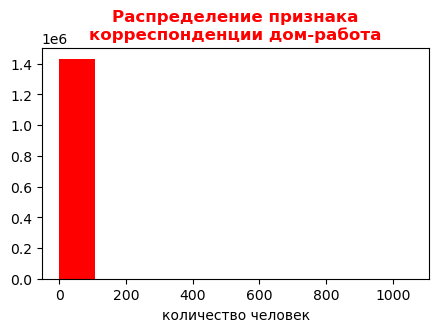

In [24]:
# визуализация распределения признака корреспонденции дом-работа
plt.figure(figsize=(5, 3))
plt.hist(cmatrix_home_work_yes['customers_cnt'], color='r')
plt.title(f'Распределение признака\nкорреспонденции дом-работа', \
          c='r', fontweight='bold', fontsize=12)
plt.xlabel('количество человек')
plt.show()

In [25]:
# размерность данных до оъединения
cmatrix_home_work_yes.shape

(1432652, 3)

In [26]:
# объединение данных с данными административных районов
cmatrix_home_work_yes = cmatrix_home_work_yes.merge(adm, left_on='home_zid', right_on='cell_zid') \
                       .merge(adm, left_on='work_zid', right_on='cell_zid', suffixes=('_home', '_work'))
cmatrix_home_work_yes.head()

,home_zid,work_zid,customers_cnt,geometry_home,cell_zid_home,adm_name_home,okrug_name_home,sub_ter_home,area_home,conts_zid_home,centroid_home,geometry_work,cell_zid_work,adm_name_work,okrug_name_work,sub_ter_work,area_work,conts_zid_work,centroid_work
0,33262,95037,1,"MULTIPOLYGON (((37.03343 55.14751, 37.03341 55...",33262,Роговское,Троицкий административный округ,Новая Москва,0.25,1,POINT (37.03802 55.14745),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200)
1,35730,95037,1,"MULTIPOLYGON (((37.03309 55.17622, 37.03304 55...",35730,Роговское,Троицкий административный округ,Новая Москва,0.25,1,POINT (37.03699 55.17848),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200)
2,43408,95037,1,"MULTIPOLYGON (((37.09506 55.25730, 37.09502 55...",43408,Роговское,Троицкий административный округ,Новая Москва,0.25,1,POINT (37.09897 55.25955),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200)
3,43936,95037,1,"MULTIPOLYGON (((37.15794 55.26198, 37.15790 55...",43936,Вороновское,Троицкий административный округ,Новая Москва,0.25,1,POINT (37.16185 55.26424),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200)
4,43938,95037,1,"MULTIPOLYGON (((37.17367 55.26202, 37.17363 55...",43938,Вороновское,Троицкий административный округ,Новая Москва,0.25,1,POINT (37.17758 55.26428),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200)


In [27]:
# размерность после объединения
cmatrix_home_work_yes.shape

(3272961, 19)

Размерность данных изменилась. Ранее при анализе геоданных Московской агломерации было установлено, что в отдельные сектора попадают границы нескольких административных районов. При этом площадь административных районов не всегда пропорциональна друг другу. В результате чего при объединении данных происходит искажение изменения численности населения.

In [28]:
# проверка соответствия наложения секторов
(cmatrix_home_work_yes['conts_zid_home'] != cmatrix_home_work_yes['conts_zid_work']).sum()

1977265

Наложение секторов не соответствует друг другу. При анализе данных за базовый сектор возьмем сектор А (из дома).

In [29]:
# пересчет показателей изменения численности населения с учетом пересечения секторов
cmatrix_home_work_yes['customers_cnt_home'] = cmatrix_home_work_yes['customers_cnt'] / cmatrix_home_work_yes['conts_zid_home']

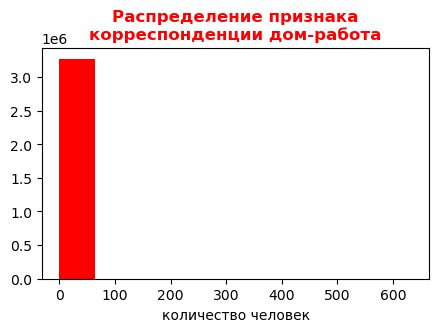

In [30]:
# визуализация распределения признака корреспонденции дом-работа
plt.figure(figsize=(5, 3))
plt.hist(cmatrix_home_work_yes['customers_cnt_home'], color='r')
plt.title(f'Распределение признака\nкорреспонденции дом-работа', \
          c='r', fontweight='bold', fontsize=12)
plt.xlabel('количество человек')
plt.show()

In [31]:
# рассчет расстояния перемещения
cmatrix_home_work_yes['centroid_home'].iloc[0].distance(cmatrix_home_work_yes['centroid_work'].iloc[0])

0.6933152450655977

In [32]:
# рассчет расстояния перемещения
cmatrix_home_work_yes['distance'] = [point_home.distance(point_work) \
                           for point_home, point_work in zip(cmatrix_home_work_yes['centroid_home'].values, \
                                                             cmatrix_home_work_yes['centroid_work'].values)]

In [33]:
# вывод данных
cmatrix_home_work_yes.head()

,home_zid,work_zid,customers_cnt,geometry_home,cell_zid_home,adm_name_home,okrug_name_home,sub_ter_home,area_home,conts_zid_home,...,geometry_work,cell_zid_work,adm_name_work,okrug_name_work,sub_ter_work,area_work,conts_zid_work,centroid_work,customers_cnt_home,distance
0,33262,95037,1,"MULTIPOLYGON (((37.03343 55.14751, 37.03341 55...",33262,Роговское,Троицкий административный округ,Новая Москва,0.25,1,...,"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200),1.0,0.693315
1,35730,95037,1,"MULTIPOLYGON (((37.03309 55.17622, 37.03304 55...",35730,Роговское,Троицкий административный округ,Новая Москва,0.25,1,...,"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200),1.0,0.672275
2,43408,95037,1,"MULTIPOLYGON (((37.09506 55.25730, 37.09502 55...",43408,Роговское,Троицкий административный округ,Новая Москва,0.25,1,...,"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200),1.0,0.571708
3,43936,95037,1,"MULTIPOLYGON (((37.15794 55.26198, 37.15790 55...",43936,Вороновское,Троицкий административный округ,Новая Москва,0.25,1,...,"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200),1.0,0.523260
4,43938,95037,1,"MULTIPOLYGON (((37.17367 55.26202, 37.17363 55...",43938,Вороновское,Троицкий административный округ,Новая Москва,0.25,1,...,"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,Старая Москва,0.25,1,POINT (37.52392 55.64200),1.0,0.512469


In [34]:
# признаки данных
cmatrix_home_work_yes.columns

Index(['home_zid', 'work_zid', 'customers_cnt', 'geometry_home',
       'cell_zid_home', 'adm_name_home', 'okrug_name_home', 'sub_ter_home',
       'area_home', 'conts_zid_home', 'centroid_home', 'geometry_work',
       'cell_zid_work', 'adm_name_work', 'okrug_name_work', 'sub_ter_work',
       'area_work', 'conts_zid_work', 'centroid_work', 'customers_cnt_home',
       'distance'],
      dtype='object')

In [35]:
# удаление лишних признаков
cmatrix_home_work_yes = cmatrix_home_work_yes.drop(columns=['home_zid', 'work_zid', 'sub_ter_home', \
                                                            'sub_ter_work', 'conts_zid_home', 'conts_zid_work'])

In [36]:
# вывод данных
cmatrix_home_work_yes.head()

,customers_cnt,geometry_home,cell_zid_home,adm_name_home,okrug_name_home,area_home,centroid_home,geometry_work,cell_zid_work,adm_name_work,okrug_name_work,area_work,centroid_work,customers_cnt_home,distance
0,1,"MULTIPOLYGON (((37.03343 55.14751, 37.03341 55...",33262,Роговское,Троицкий административный округ,0.25,POINT (37.03802 55.14745),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.693315
1,1,"MULTIPOLYGON (((37.03309 55.17622, 37.03304 55...",35730,Роговское,Троицкий административный округ,0.25,POINT (37.03699 55.17848),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.672275
2,1,"MULTIPOLYGON (((37.09506 55.25730, 37.09502 55...",43408,Роговское,Троицкий административный округ,0.25,POINT (37.09897 55.25955),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.571708
3,1,"MULTIPOLYGON (((37.15794 55.26198, 37.15790 55...",43936,Вороновское,Троицкий административный округ,0.25,POINT (37.16185 55.26424),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.523260
4,1,"MULTIPOLYGON (((37.17367 55.26202, 37.17363 55...",43938,Вороновское,Троицкий административный округ,0.25,POINT (37.17758 55.26428),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.512469


### Анализ матрицы корреспонденции дом-работа одного из округов

In [37]:
# выборка данных по выбранному округу
troitsky_okrug = cmatrix_home_work_yes[cmatrix_home_work_yes['okrug_name_home'] == 'Троицкий административный округ']
troitsky_okrug.head()

,customers_cnt,geometry_home,cell_zid_home,adm_name_home,okrug_name_home,area_home,centroid_home,geometry_work,cell_zid_work,adm_name_work,okrug_name_work,area_work,centroid_work,customers_cnt_home,distance
0,1,"MULTIPOLYGON (((37.03343 55.14751, 37.03341 55...",33262,Роговское,Троицкий административный округ,0.25,POINT (37.03802 55.14745),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.693315
1,1,"MULTIPOLYGON (((37.03309 55.17622, 37.03304 55...",35730,Роговское,Троицкий административный округ,0.25,POINT (37.03699 55.17848),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.672275
2,1,"MULTIPOLYGON (((37.09506 55.25730, 37.09502 55...",43408,Роговское,Троицкий административный округ,0.25,POINT (37.09897 55.25955),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.571708
3,1,"MULTIPOLYGON (((37.15794 55.26198, 37.15790 55...",43936,Вороновское,Троицкий административный округ,0.25,POINT (37.16185 55.26424),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.523260
4,1,"MULTIPOLYGON (((37.17367 55.26202, 37.17363 55...",43938,Вороновское,Троицкий административный округ,0.25,POINT (37.17758 55.26428),"MULTIPOLYGON (((37.51995 55.63976, 37.51995 55...",95037,Коньково,Юго-Западный административный округ,0.25,POINT (37.52392 55.64200),1.0,0.512469


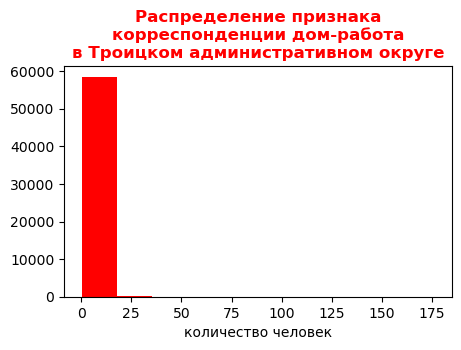

In [38]:
# визуализация распределения признака корреспонденции дом-работа
plt.figure(figsize=(5, 3))
plt.hist(troitsky_okrug['customers_cnt_home'], color='r')
plt.title(f'Распределение признака\nкорреспонденции дом-работа\nв Троицком административном округе', \
          c='r', fontweight='bold', fontsize=12)
plt.xlabel('количество человек')
plt.show()

### Предлагаемые показатели корреспонденции дом-работа Московской агломерации

In [39]:
# расчет обеспеченности округа рабочими местами
(troitsky_okrug['okrug_name_home'] == troitsky_okrug['okrug_name_work']).sum() / troitsky_okrug.shape[0] *100

48.67359100970543

**48,7%**  жителей Тройцкого административного округа работают не покидая свой округ

In [40]:
# количество жителей в округе
troitsky_okrug.groupby('okrug_name_home')['customers_cnt_home'].sum()

okrug_name_home
Троицкий административный округ    80466.333333
Name: customers_cnt_home, dtype: float64

In [41]:
df = pd.Series([1], index=[1])
df

1    1
dtype: int64

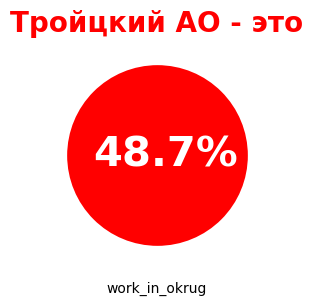

In [42]:
# визуализация количества округов, субъектов и административных районов Московской агломерации
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(df, x=df.index, y=df.values, size=61.5, \
                sizes=[20000], c='r', legend=False)
plt.annotate('48.7%', xy=(0.97, 0.995), fontsize=30, weight='bold', c='w')
plt.box(on=None)
plt.xticks([])
plt.yticks([])
plt.xlabel('work_in_okrug')
plt.title('Тройцкий АО - это', loc='center', fontweight='bold', color='r', fontsize=20)
plt.show()

In [43]:
(troitsky_okrug['adm_name_home'] == troitsky_okrug['adm_name_work']).sum() / troitsky_okrug.shape[0] *100

30.064702877575343

**30%** жителей административных районов Тройцкого административного округа работают в своем административном районе

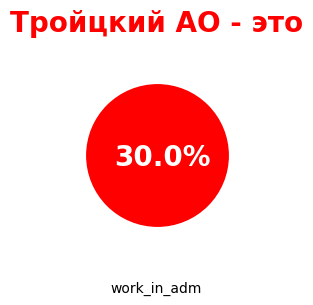

In [44]:
# визуализация количества округов, субъектов и административных районов Московской агломерации
fig, ax = plt.subplots(figsize=(3, 3))
sns.scatterplot(df, x=df.index, y=df.values, size=61.5, \
                sizes=[12500], c='r', legend=False)
plt.annotate('30.0%', xy=(0.98, 0.995), fontsize=20, weight='bold', c='w')
plt.box(on=None)
plt.xticks([])
plt.yticks([])
plt.xlabel('work_in_adm')
plt.title('Тройцкий АО - это', loc='center', fontweight='bold', color='r', fontsize=20)
plt.show()

In [45]:
# подсчет отношения жителей работающих в своем административном районе
troitsky_okrug_adm_work = (troitsky_okrug.groupby(['adm_name_work', 'adm_name_home'])['customers_cnt_home'].sum() / \
                          troitsky_okrug.groupby('adm_name_home')['customers_cnt_home'].sum() *100).to_frame().reset_index()
troitsky_okrug_adm_work.head()

,adm_name_work,adm_name_home,customers_cnt_home
0,Академический,Вороновское,0.496590
1,Академический,Киевский,0.417257
2,Академический,Кленовское,0.140107
3,Академический,Краснопахорское,0.575931
4,Академический,Михайлово-Ярцевское,0.563435


In [46]:
# выборка административных районов Троицкого административного округа
troitsky_okrug_adm_work = troitsky_okrug_adm_work[troitsky_okrug_adm_work['adm_name_work'] \
                                                  .isin(troitsky_okrug_adm_work['adm_name_home'].unique())]
troitsky_okrug_adm_work.head()

,adm_name_work,adm_name_home,customers_cnt_home
188,Вороновское,Вороновское,59.334109
189,Вороновское,Киевский,0.543924
190,Вороновское,Кленовское,6.662861
191,Вороновское,Краснопахорское,1.849441
192,Вороновское,Михайлово-Ярцевское,2.868043


In [47]:
# отношения жителей работающих в своем административном районе
troitsky_okrug_adm_work = troitsky_okrug_adm_work[troitsky_okrug_adm_work['adm_name_work'] == \
                                                  troitsky_okrug_adm_work['adm_name_home']]
troitsky_okrug_adm_work

,adm_name_work,adm_name_home,customers_cnt_home
188,Вороновское,Вороновское,59.334109
383,Киевский,Киевский,44.601744
391,Кленовское,Кленовское,55.259198
462,Краснопахорское,Краснопахорское,44.427443
654,Михайлово-Ярцевское,Михайлово-Ярцевское,40.140859
793,Новофедоровское,Новофедоровское,46.675839
872,Первомайское,Первомайское,40.286415
960,Роговское,Роговское,57.662870
1172,Троицк,Троицк,43.144748
1318,Щаповское,Щаповское,57.199776


In [48]:
# отношения жителей работающих в своем административном районе
troitsky_okrug_adm_work = troitsky_okrug_adm_work.drop(columns='adm_name_work').rename(columns={'adm_name_home' : 'adm_name'})
troitsky_okrug_adm_work

,adm_name,customers_cnt_home
188,Вороновское,59.334109
383,Киевский,44.601744
391,Кленовское,55.259198
462,Краснопахорское,44.427443
654,Михайлово-Ярцевское,40.140859
793,Новофедоровское,46.675839
872,Первомайское,40.286415
960,Роговское,57.662870
1172,Троицк,43.144748
1318,Щаповское,57.199776


In [49]:
# рейтинг административных районов
troitsky_okrug_adm_work_rank = troitsky_okrug_adm_work.set_index('adm_name') \
                              .sort_values(by='customers_cnt_home', ascending=False).rank(ascending=True)
troitsky_okrug_adm_work_rank

,customers_cnt_home
adm_name,
Вороновское,10.0
Роговское,9.0
Щаповское,8.0
Кленовское,7.0
Новофедоровское,6.0
Киевский,5.0
Краснопахорское,4.0
Троицк,3.0
Первомайское,2.0


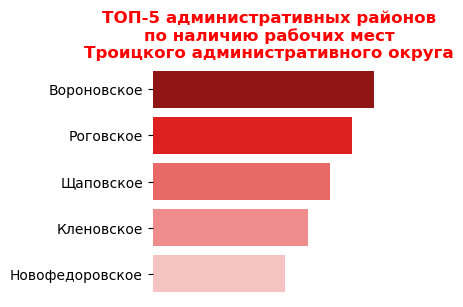

In [50]:
# визуализация рейтинг административных районов
plt.figure(figsize=(3,3))
sns.barplot(x = troitsky_okrug_adm_work_rank['customers_cnt_home'].values[:5], y = troitsky_okrug_adm_work_rank.index[:5], \
            palette=sns.color_palette(colors))
plt.title('ТОП-5 административных районов\nпо наличию рабочих мест\nТроицкого административного округа', \
          c='r', fontweight='bold', fontsize=12)
plt.xticks([])
plt.box(on=None)
plt.ylabel('')
plt.show()

In [51]:
# антирейтинг административных районов
troitsky_okrug_adm_work_rank = troitsky_okrug_adm_work.set_index('adm_name') \
                              .sort_values(by='customers_cnt_home', ascending=True).rank(ascending=False)
troitsky_okrug_adm_work_rank

,customers_cnt_home
adm_name,
Михайлово-Ярцевское,10.0
Первомайское,9.0
Троицк,8.0
Краснопахорское,7.0
Киевский,6.0
Новофедоровское,5.0
Кленовское,4.0
Щаповское,3.0
Роговское,2.0


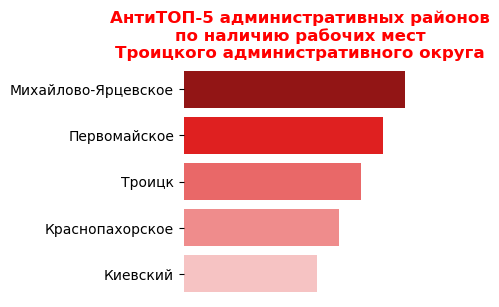

In [52]:
# визуализация рейтинг административных районов
plt.figure(figsize=(3,3))
sns.barplot(x = troitsky_okrug_adm_work_rank['customers_cnt_home'].values[:5], y = troitsky_okrug_adm_work_rank.index[:5], \
            palette=sns.color_palette(colors))
plt.title('АнтиТОП-5 административных районов\nпо наличию рабочих мест\nТроицкого административного округа', \
          c='r', fontweight='bold', fontsize=12)
plt.xticks([])
plt.box(on=None)
plt.ylabel('')
plt.show()

In [53]:
# расчет средней дистанции перемещения по административным районам
troitsky_okrug.groupby('adm_name_home')['distance'].mean().sort_values(ascending=True)

adm_name_home
Щаповское              0.136562
Кленовское             0.150259
Краснопахорское        0.172358
Троицк                 0.207347
Михайлово-Ярцевское    0.211006
Первомайское           0.211243
Вороновское            0.221854
Роговское              0.256314
Новофедоровское        0.372714
Киевский               0.435835
Name: distance, dtype: float64

In [54]:
# рейтинг административных районов
troitsky_okrug_adm_work_rank = troitsky_okrug.groupby('adm_name_home')['distance'].mean() \
                               .sort_values(ascending=True).rank(ascending=False)
troitsky_okrug_adm_work_rank

adm_name_home
Щаповское              10.0
Кленовское              9.0
Краснопахорское         8.0
Троицк                  7.0
Михайлово-Ярцевское     6.0
Первомайское            5.0
Вороновское             4.0
Роговское               3.0
Новофедоровское         2.0
Киевский                1.0
Name: distance, dtype: float64

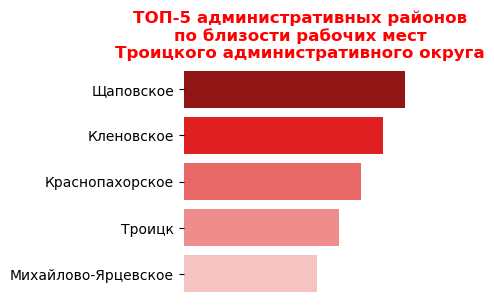

In [55]:
# визуализация рейтинг административных районов
plt.figure(figsize=(3,3))
sns.barplot(x = troitsky_okrug_adm_work_rank.values[:5], y = troitsky_okrug_adm_work_rank.index[:5], \
            palette=sns.color_palette(colors))
plt.title('ТОП-5 административных районов\nпо близости рабочих мест\nТроицкого административного округа', \
          c='r', fontweight='bold', fontsize=12)
plt.xticks([])
plt.box(on=None)
plt.ylabel('')
plt.show()

In [56]:
# антирейтинг административных районов
troitsky_okrug_adm_work_rank = troitsky_okrug.groupby('adm_name_home')['distance'].mean() \
                               .sort_values(ascending=False).rank(ascending=True)
troitsky_okrug_adm_work_rank

adm_name_home
Киевский               10.0
Новофедоровское         9.0
Роговское               8.0
Вороновское             7.0
Первомайское            6.0
Михайлово-Ярцевское     5.0
Троицк                  4.0
Краснопахорское         3.0
Кленовское              2.0
Щаповское               1.0
Name: distance, dtype: float64

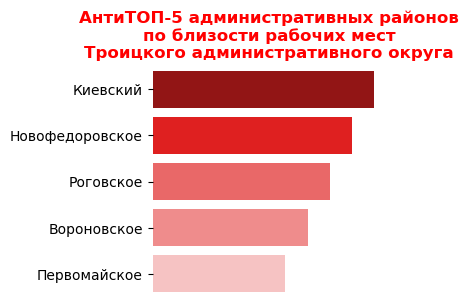

In [57]:
# визуализация рейтинг административных районов
plt.figure(figsize=(3,3))
sns.barplot(x = troitsky_okrug_adm_work_rank.values[:5], y = troitsky_okrug_adm_work_rank.index[:5], \
            palette=sns.color_palette(colors))
plt.title('АнтиТОП-5 административных районов\nпо близости рабочих мест\nТроицкого административного округа', \
          c='r', fontweight='bold', fontsize=12)
plt.xticks([])
plt.box(on=None)
plt.ylabel('')
plt.show()